In [14]:
import torch
import numpy as np

from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
#num of subprocesses to use for data loading
num_workers = 0
batch_size = 640
#validation percentage
valid_size = 0.2

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.EMNIST(root = 'MNIST_data', 
                             split = 'byclass',
                             train=True,
                             download=True,
                             transform=transform)
test_data = datasets.EMNIST(root = 'MNIST_data', 
                             split = 'byclass',
                             train=False,
                             download=True,
                             transform=transform)

In [ ]:
#get indices for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [ ]:
#define samplers for obtaining batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, 
                                           num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = valid_sampler, 
                                           num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                           num_workers = num_workers)

<h2><b>Visualise data</b></h2>

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
#obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()) if labels[idx]<10 else letters[labels[idx].item()])

<h2><b>Define Architecture</b></h2>

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class Three_Block(nn.Module):
    def __init__(self, upscale_factor):
        super(Three_Block, self).__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, 5, 1, 2)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

In [27]:
model = Three_Block(2)
print(model)

Three_Block(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=2)
)


<h2><b>Specify Loss and Optimization Functions</b></h2>

In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)

<h2><b>(Optional)Load weights if you want to retrain model</b></h2>

torch.Size([1, 3, 432, 1028])


RuntimeError: value cannot be converted to type uint8_t without overflow: -0.112934

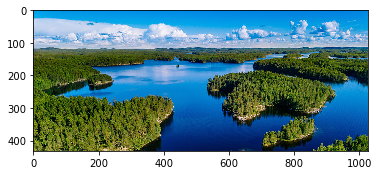

In [29]:
#model.load_state_dict(torch.load('model_SISR.pt'))

img = mpimg.imread('./test.jpg')
imgplot = plt.imshow(img)
img = (torch.tensor([img])).permute(0,3,1,2)
#transforms.ToTensor()(img)

print(img.shape)
imgplot = plt.imshow(model(img))

<h2><b>Train Network</b></h2>

Steps:
<ul>
    <li>start with 3 blocks</li>
    <li>train for 2000 epochs</li>
    <li>create new inputs using model and current training data</li>
    <li>train 3 more separate blocks</li>
    <li>test complete NN</li>
</ul>

<ul>
    <li>Clear grads</li>
    <li>Forward prop</li>
    <li>Loss calc</li>
    <li>Back prop</li>
    <li>Optimization step</li>
    <li>Update average training loss</li>
</ul>

In [ ]:
epochs = 2000
#init min validation loss
valid_loss_min = np.Inf

for epoch in range(epochs):
    batch_num=0

    train_loss = 0.0
    valid_loss = 0.0

    train_acc=0.0
    val_acc=0.0
    
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        batch_num+=1
    
    model.eval()
    for data, target in valid_loader:
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss+=loss.item()*data.size(0)
        
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
        
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1,
        train_acc/batch_num * 100,
        val_acc/batch_num * 100
    ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_EMNIST_CNN.pt')
        valid_loss_min = valid_loss

model.load_state_dict(torch.load('model_EMNIST_CNN.pt'))

<h2><b>Test the Trained Network</b></h2>

test_loss = 0.0
class_correct = list(0. for i in range (62))
class_total = list(0. for i in range (62))

model.eval()

for data, target in test_loader:
    data = data.cuda()
    target = target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    #compare pred to label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6}\n'.format(test_loss))

for i in range(62):
    if class_total[i] > 0:
      if (100*class_correct[i]/class_total[i] < 50):
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i) if i<10 else letters[i],
            100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i]))
        )
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. *np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total))
     )

<h2><b>Visualize Sample test Results</b></h2>

dataiter = iter(test_loader)
images , labels = dataiter.next()

images = images.cuda()
labels = labels.cuda()
output = model(images)
_, preds = torch.max(output, 1)
images = torch.Tensor.cpu(images).numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(
        str(str(preds[idx].item()) if preds[idx]<10 else letters[preds[idx].item()]),
        str(str(labels[idx].item()) if labels[idx]<10 else letters[labels[idx].item()])), 
        color = ("green" if preds[idx] == labels[idx] else "red"))

